# Simple approach - Autoencoder for anomaly detection

#Loading and Understanding the data

In this colab we will get the data we just collected through CoolTerm, load it, and understad it.



In [ ]:
#Get the necessary packages (importing libraries and dependecies)
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
from scipy import stats

#set the threshhold of prinitng data to console to maximum value
#so avoid the loss of data on console while displaying
np.set_printoptions(threshold=sys.maxsize)
# setting up a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

##Get the data

You will have to manually upload the .txt files in colab (for now) in order to get access to the raw data.

We will define a function **readData()** to get access in the .txt files and also give names to the columns.

🔑**Note:** We start with a smaller datset so we can experiment quickly and experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [ ]:
#--------------To read the data from a file
# defining function for loading the dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['x-axis','y-axis','z-axis']
    #read the specified file using pandas function and return the data
    data = pd.read_csv(filePath, header=None, names=columnNames, sep='\t', na_values=';')
    return data

In [ ]:
# Read The Data
capture = "1"
hertz = "60"
volume = "30"
filename = "capture" + capture + "_" + hertz + "hz_" + volume + "vol.txt"
dataset = readData(filename)

# Add a new column for sequential timestamps
dataset['timestamp'] = np.arange(1, len(dataset) + 1)

dataset

x-axis  y-axis  z-axis  timestamp
0        0.03   -0.07    0.70          1
1       -0.10    0.04    1.20          2
2        0.03   -0.07    0.71          3
3       -0.10    0.04    1.20          4
4        0.03   -0.07    0.71          5
...       ...     ...     ...        ...
36309   -0.01   -0.01    0.96      36310
36310   -0.00    0.01    1.14      36311
36311   -0.01   -0.01    0.97      36312
36312   -0.00    0.01    1.14      36313
36313   -0.01   -0.01    0.98      36314

[36314 rows x 4 columns]

now trying on an anomalous/different vibration pattern

In [ ]:
# Read The Data
capture_a = "2"
hertz_a = "40"
volume_a = "60"
filename_a = "capture" + capture_a + "_" + hertz_a + "hz_" + volume_a + "vol.txt"
anomalous_dataset = readData(filename_a)

# Add a new column for sequential timestamps
anomalous_dataset['timestamp'] = np.arange(1, len(anomalous_dataset) + 1)

anomalous_dataset

x-axis  y-axis  z-axis  timestamp
0        0.07   -0.05    0.91          1
1       -0.02   -0.00    1.06          2
2       -0.00    0.01    1.08          3
3        0.06   -0.04    0.93          4
4       -0.02    0.00    1.02          5
...       ...     ...     ...        ...
36075   -0.03    0.01    0.91      36076
36076    0.00   -0.01    1.08      36077
36077   -0.01    0.01    0.95      36078
36078   -0.03    0.02    0.94      36079
36079    0.01   -0.01    1.06      36080

[36080 rows x 4 columns]

## Inspect the data (become one with it)

A very crucial step at the beginning of any ML project is becoming one with the data. So we saw that the data was properly place in the *dataset* variable. Now, in order to have a better visualization of the data we will plot it.

In [ ]:
# defining the function to plot a single axis data
# setup color, title, limit and add grid.
def plotAxis(axis, x, y, title):
    axis.plot(x, y, color='green', linewidth=1)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

# defining a function to plot the data for a given vibration pattern
def plotVibPattern(data, hz, vol):
    # make subplots of x, y, z over timestamp
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, data['timestamp'], data['x-axis'], 'X-AXIS')
    plotAxis(ax1, data['timestamp'], data['y-axis'], 'Y-AXIS')
    plotAxis(ax2, data['timestamp'], data['z-axis'], 'Z-AXIS')
    # set the size and title
    plt.subplots_adjust(hspace=0.2)
    title = "Accelerometer data for " + hz + "HZ and " + vol + " volume"
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

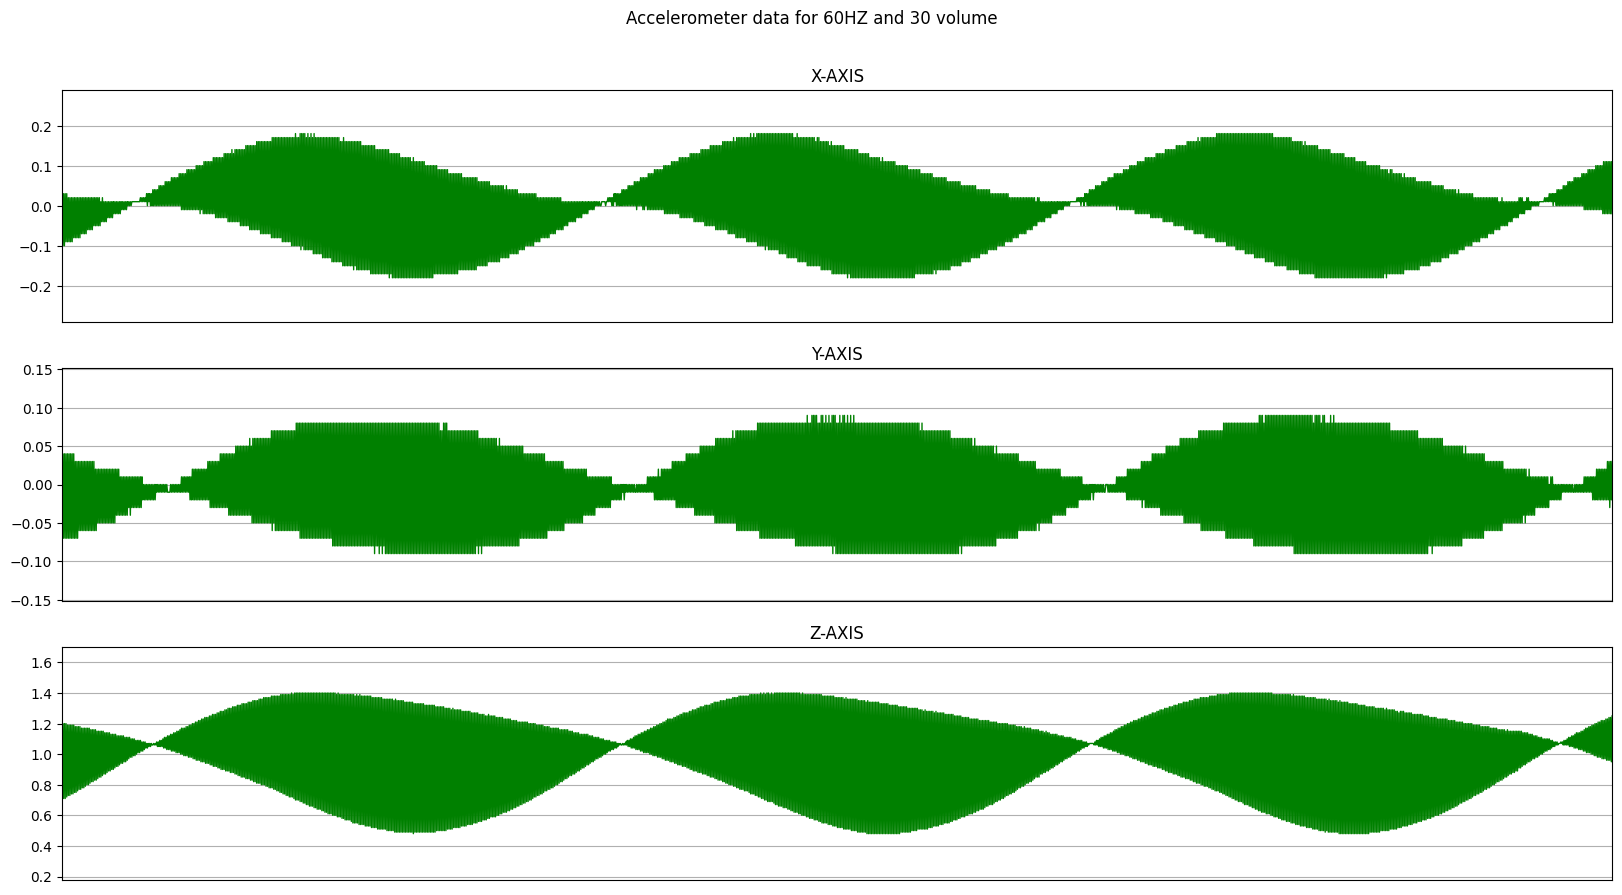

In [ ]:
#select a subset of 2000 samples
subset = dataset[:2000]
plotVibPattern(subset, hertz, volume)


let's also see the anomalous dataset

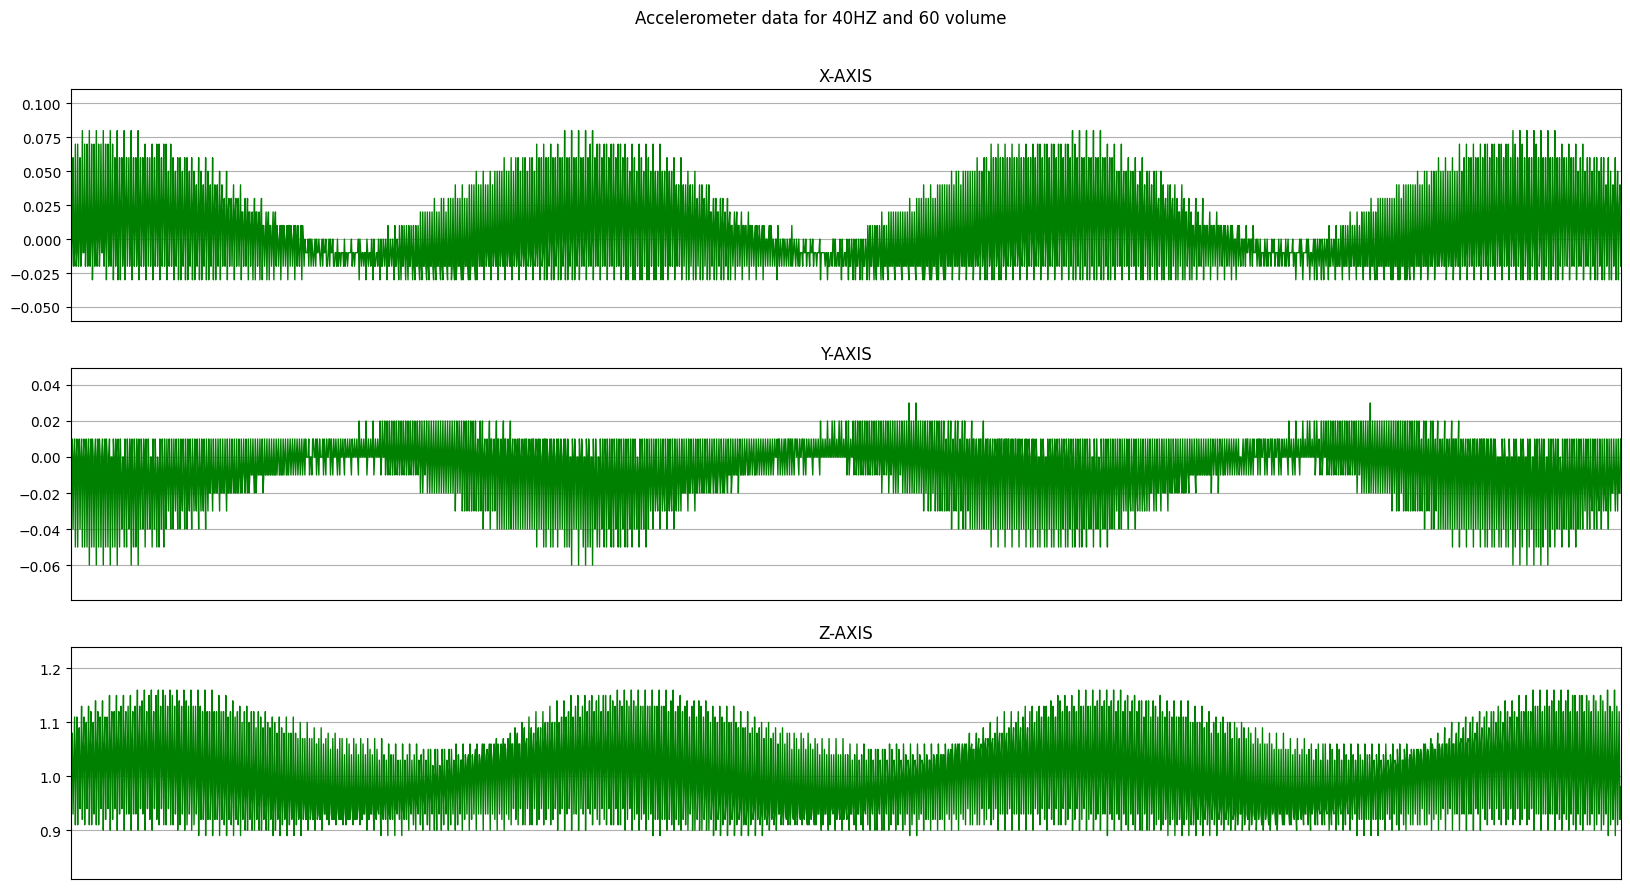

In [ ]:
#select a subset of 2000 samples
anomaly_subset = anomalous_dataset[:2000]
plotVibPattern(anomaly_subset, hertz_a, volume_a)

OK! we can definitely see a pattern in all 3 datasets we gathered.

I will now continue testing and also preprocessing the data from the 60hz and 30 volume dataset.

In [ ]:
# Pick a random row from the dataset
random_reading = dataset.sample(n=1)

# our data is actually giant arrays/tensors
#ternsors are inputs to our neural networks
tf.constant(random_reading)

#you can also see the entire dataset as tensors (it'll take a bit longer to compute)
#using this command: tf.constant(dataset)
tf.constant(dataset)

<tf.Tensor: shape=(36314, 4), dtype=float64, numpy=
array([[ 3.0000e-02, -7.0000e-02,  7.0000e-01,  1.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  2.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  3.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  4.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  5.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.2000e+00,  6.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.2000e-01,  7.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  8.0000e+00],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  9.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.0000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  1.1000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.2000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.3000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.4000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.5000e+01],
       [-8.0000e-02,  4.0000e-02,

In [ ]:
#view the image shape
random_reading.shape #returns one row, 4 columns

(1, 4)

##Splitting the data
Now that we have a reasonable dataset we can work with it is time to start thinking about our neural network. Hence, the first step is to split the data.

I will use the cross-validation method so that we can also test the generazibility of the model.

Partition the data into training and validation, and testing partitions. Train the network using the 70% of the data and 20% for validaiton. Then, set aside 10% for testing.

In this code, train_test_split is used twice to first split the data into training (70%) and a combination of validation and testing (30%). Then, the validation and testing sets are split from the combined set, resulting in a 20% validation set and a 10% testing set.

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into 70% training, 20% validation, and 10% testing without shuffling
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42, shuffle=False)

# Print the shapes of the resulting sets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (25419, 4)
Validation data shape: (7299, 4)
Testing data shape: (3596, 4)


I will not split the data for the anomalous dataset as I will only train the autoencoder to recognize a certain vibration

In [ ]:
dataset.shape

(36314, 4)

##Preprocessing the data

🔑**Note**: As we've discussed before, many ML models, including NNs prefer the values they work with the be between 0 and 1. Knowing this, one of the most common preprocessing steps  is to **normalize** the data. In our case, having just values which are in a certain range we can apply the Min-Max scaling formula.

We will also normalize the validation and test sets but based on thee fit scalar of training

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming train_data, val_data, and test_data are Pandas DataFrames
# Also assuming that your data has more than 3 columns

# Extracting the first 3 columns for normalization
cols_to_normalize = [0, 1, 2]  # Replace with the actual column indices

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
norm_train_data = train_data.copy()  # Make a copy to avoid modifying the original data
norm_train_data.iloc[:, cols_to_normalize] = scaler.fit_transform(train_data.iloc[:, cols_to_normalize])

# Transform the validation data using the same scaler
norm_val_data = val_data.copy()
norm_val_data.iloc[:, cols_to_normalize] = scaler.transform(val_data.iloc[:, cols_to_normalize])

# Transform the test data using the same scaler
norm_test_data = test_data.copy()
norm_test_data.iloc[:, cols_to_normalize] = scaler.transform(test_data.iloc[:, cols_to_normalize])

In [ ]:
norm_train_data

x-axis    y-axis    z-axis  timestamp
0      0.565217  0.208333  0.275510          1
1      0.282609  0.666667  0.785714          2
2      0.565217  0.208333  0.285714          3
3      0.282609  0.666667  0.785714          4
4      0.565217  0.208333  0.285714          5
...         ...       ...       ...        ...
25414  0.521739  0.291667  0.418367      25415
25415  0.391304  0.583333  0.755102      25416
25416  0.500000  0.291667  0.428571      25417
25417  0.413043  0.583333  0.755102      25418
25418  0.500000  0.291667  0.438776      25419

[25419 rows x 4 columns]

In [ ]:
norm_test_data

x-axis    y-axis    z-axis  timestamp
32718  0.586957  0.458333  0.683673      32719
32719  0.456522  0.500000  0.642857      32720
32720  0.608696  0.458333  0.683673      32721
32721  0.456522  0.500000  0.642857      32722
32722  0.608696  0.458333  0.673469      32723
...         ...       ...       ...        ...
36309  0.478261  0.458333  0.540816      36310
36310  0.500000  0.541667  0.724490      36311
36311  0.478261  0.458333  0.551020      36312
36312  0.500000  0.541667  0.724490      36313
36313  0.478261  0.458333  0.561224      36314

[3596 rows x 4 columns]

I will though normalize the anomalous data with MinMaxScaling same as for the normal dataset so that we can make them comparable

In [ ]:
# Create an instance of MinMaxScaler
scaler_a = MinMaxScaler()

# Fit and transform the training data
norm_anomalous_data = anomalous_dataset.copy()  # Make a copy to avoid modifying the original data
norm_anomalous_data.iloc[:, cols_to_normalize] = scaler.fit_transform(norm_anomalous_data.iloc[:, cols_to_normalize])

In [ ]:
norm_anomalous_data

x-axis  y-axis    z-axis  timestamp
0      0.800000     0.2  0.166667          1
1      0.200000     0.7  0.666667          2
2      0.333333     0.8  0.733333          3
3      0.733333     0.3  0.233333          4
4      0.200000     0.7  0.533333          5
...         ...     ...       ...        ...
36075  0.133333     0.8  0.166667      36076
36076  0.333333     0.6  0.733333      36077
36077  0.266667     0.8  0.300000      36078
36078  0.133333     0.9  0.266667      36079
36079  0.400000     0.6  0.666667      36080

[36080 rows x 4 columns]

To verify that the behaviour did not change after the normalization we can plot again on the newly updated data.

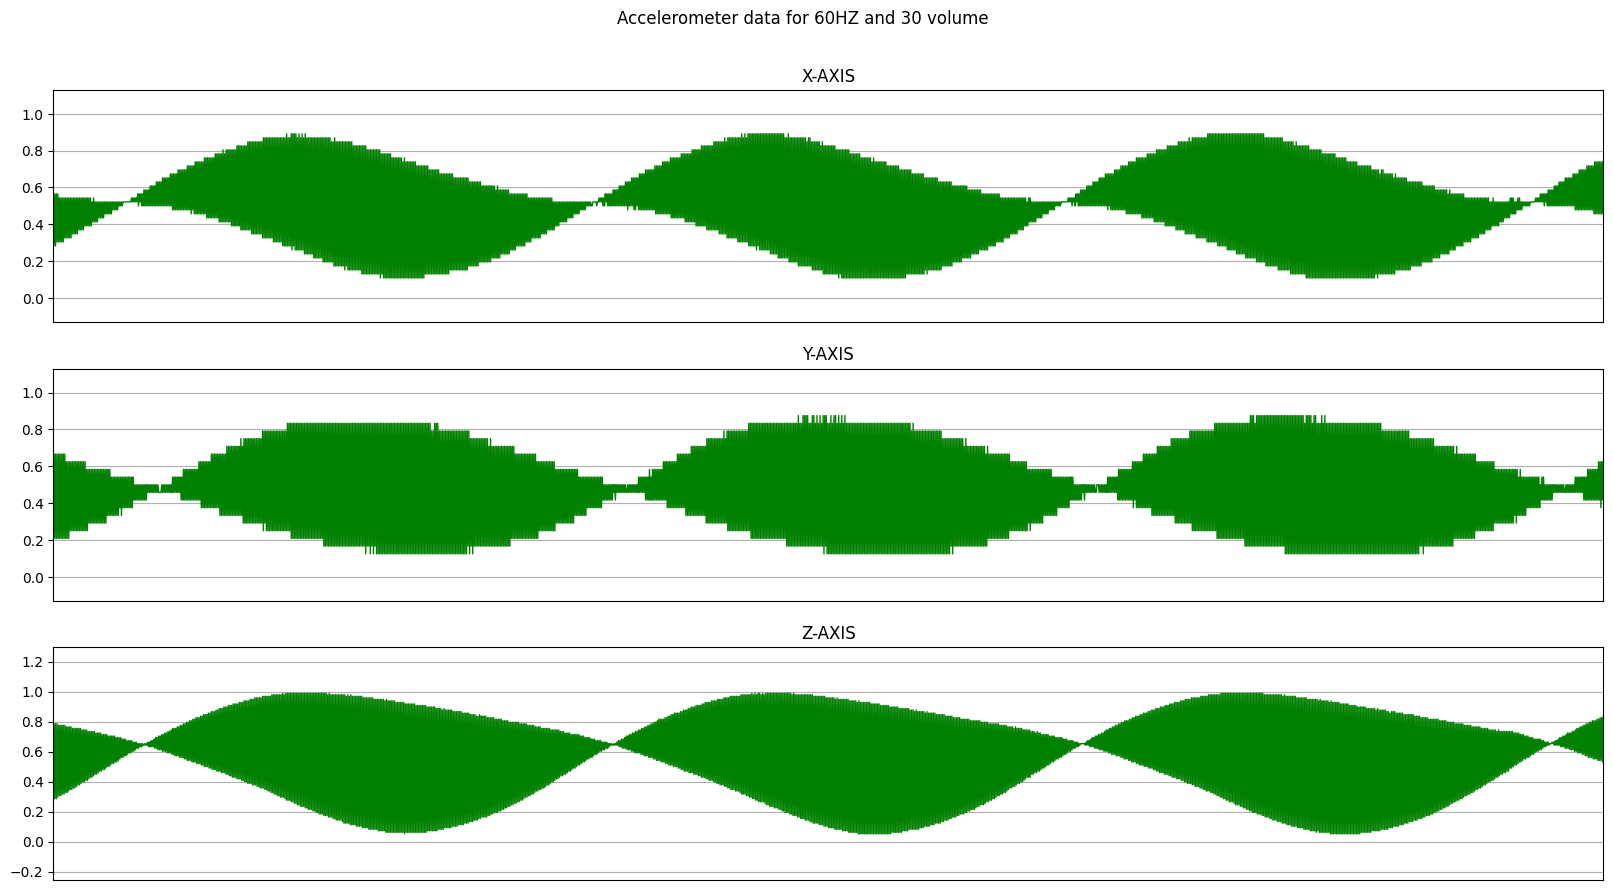

In [ ]:
#select a subset of 2000 samples
subset = norm_train_data[:2000]
plotVibPattern(subset, hertz, volume)

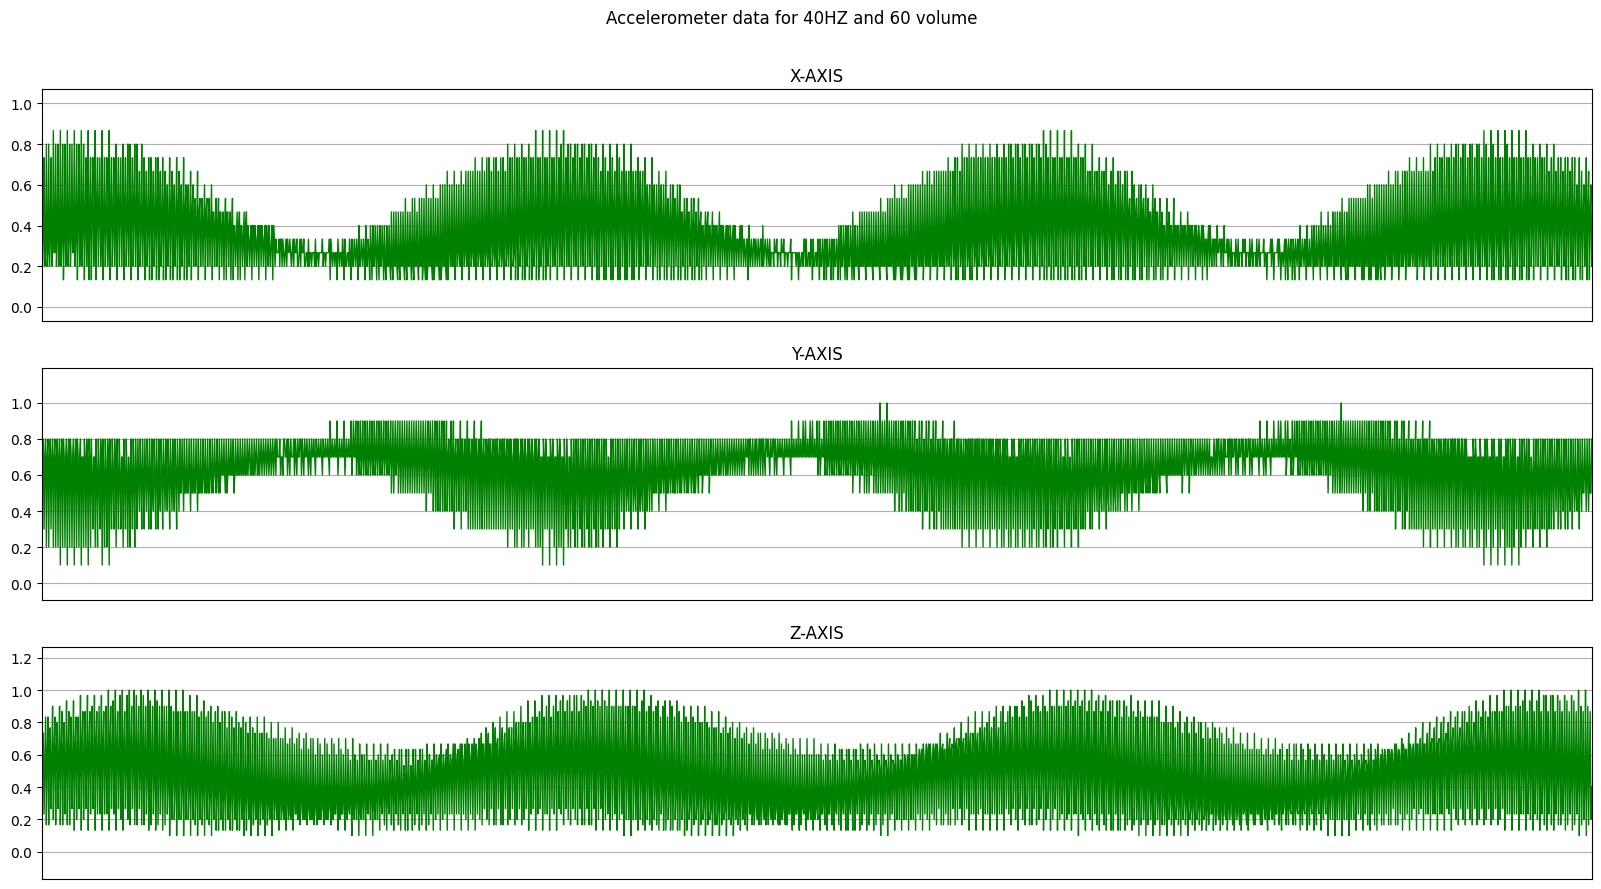

In [ ]:
#select a subset of 2000 samples
anomaly_subset = norm_anomalous_data[:2000]
plotVibPattern(anomaly_subset, hertz_a, volume_a)

As seen in the plot, the behaviour is intact which is exactly what we wanted.

In [ ]:
# Drop the 'timestamp' column
norm_train_data = norm_train_data.drop(columns=['timestamp'])
norm_val_data = norm_val_data.drop(columns=['timestamp'])
norm_test_data = norm_test_data.drop(columns=['timestamp'])
norm_anomalous_data = norm_anomalous_data.drop(columns = ['timestamp'])

## Picking an Embedding to Build the Model

Note: Changing the size of the embedding (the smallest layer) can produce interesting results. We can also go for layer sizes (we need to experiment).

In [ ]:
from keras.models import Model
from keras import layers, losses

class AnomalyDetector(Model):
  # This is the constructor method for the AnomalyDetector class, where the architecture of the autoencoder is defined.
  def __init__(self):
    #calls the constructor of the parent class (tf.keras.Model) to properly initialize the model.
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu", input_shape = (3, )),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")]) # Smallest Layer Defined Here

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(3, activation="sigmoid")])

  #This method defines the forward pass of the autoencoder model. It takes the input x, which represents the ECG signals.
  #The x is first passed through the encoder, and the resulting compressed representation is obtained.
  #The compressed representation is then passed through the decoder to reconstruct the original ECG signals.
  #The reconstructed signals are returned as the output of the autoencoder.
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

#This line creates an instance of the AnomalyDetector class, creating an autoencoder model.
autoencoder = AnomalyDetector()

In [ ]:
#MAE measures the absolute difference between the original input and the reconstructed output and is commonly used for autoencoders.
autoencoder.compile(optimizer='adam', loss='mae')

## Train the model

Notice that the autoencoder is trained using only the normal accelerometer data, but is evaluated using the full test set.

- train_data: The input data used for training the autoencoder. This consists of normal (non-anomalous) accelerometer data.
- train_data: The target data used for training. In this case, the target data is the same as the input data because the autoencoder aims to reconstruct the input data.
- epochs=50: The number of epochs represents how many times the entire training dataset will be used to train the model. One epoch means the model has seen each data point in the training set once.
- batch_size=512: The batch size specifies the number of data points that will be fed to the model in each iteration during training. A larger batch size might lead to faster training, but it requires more memory.
- validation_data=(test_data, test_data): During training, this data is used to evaluate the model's performance after each epoch. The test_data can contains normal accelerometer data for validation.
- shuffle=True: If True, the training data will be shuffled at the beginning of each epoch. Shuffling the data helps in reducing the bias introduced by the order of the data points during training.

After training, the autoencoder model will be capable of compressing and reconstructing ECG signals. In an anomaly detection setting, the model can be used to detect anomalies by comparing the reconstruction error of test (normal and anomalous) ECG signals with the reconstruction error of normal training data. Anomalies are expected to have higher reconstruction errors compared to normal data.

In [ ]:
history = autoencoder.fit(norm_train_data, norm_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(norm_val_data, norm_val_data),
          shuffle=True)

Epoch 1/20
50/50 [==============================] - 9s 24ms/step - loss: 0.1874 - val_loss: 0.0864
Epoch 2/20
50/50 [==============================] - 1s 14ms/step - loss: 0.0578 - val_loss: 0.0554
Epoch 3/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0474 - val_loss: 0.0493
Epoch 4/20
50/50 [==============================] - 1s 20ms/step - loss: 0.0412 - val_loss: 0.0441
Epoch 5/20
50/50 [==============================] - 1s 22ms/step - loss: 0.0367 - val_loss: 0.0403
Epoch 6/20
50/50 [==============================] - 2s 31ms/step - loss: 0.0323 - val_loss: 0.0356
Epoch 7/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0271 - val_loss: 0.0290
Epoch 8/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0210 - val_loss: 0.0222
Epoch 9/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0185 - val_loss: 0.0278
Epoch 10/20
50/50 [==============================] - 1s 16ms/step - loss: 0.0167 - val_loss: 0.0219
Epoch 11/

Checking for overfitting

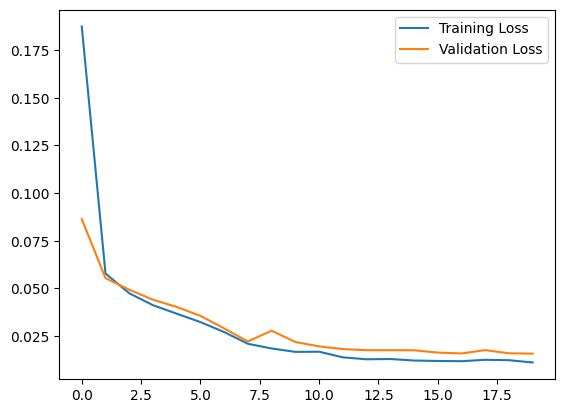

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Evaluate Training

We will now test if the model has indeed learn the patterns correcly by using our test_data which was not used in the training process. We will encode it and decode it (basically mimic the same process as in training) and see if the pattern stays the same or changes drammatically. If the pattern is similar it means our model has indeed learnt the features successfully.

In [ ]:
print(type(norm_test_data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(type(norm_anomalous_data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
norm_test_data

x-axis    y-axis    z-axis
32718  0.586957  0.458333  0.683673
32719  0.456522  0.500000  0.642857
32720  0.608696  0.458333  0.683673
32721  0.456522  0.500000  0.642857
32722  0.608696  0.458333  0.673469
...         ...       ...       ...
36309  0.478261  0.458333  0.540816
36310  0.500000  0.541667  0.724490
36311  0.478261  0.458333  0.551020
36312  0.500000  0.541667  0.724490
36313  0.478261  0.458333  0.561224

[3596 rows x 3 columns]

In [ ]:
norm_anomalous_data

x-axis  y-axis    z-axis
0      0.800000     0.2  0.166667
1      0.200000     0.7  0.666667
2      0.333333     0.8  0.733333
3      0.733333     0.3  0.233333
4      0.200000     0.7  0.533333
...         ...     ...       ...
36075  0.133333     0.8  0.166667
36076  0.333333     0.6  0.733333
36077  0.266667     0.8  0.300000
36078  0.133333     0.9  0.266667
36079  0.400000     0.6  0.666667

[36080 rows x 3 columns]

transforming the testing set into numpy for evaluation puposes. We're taking the entire test data in the sample variable

In [ ]:
sample = norm_test_data.iloc[:, :].to_numpy()

In [ ]:
sample.shape

(3596, 3)

In [ ]:
encoded_imgs = autoencoder.encoder(sample).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Create an array representing the timestamp
timestamp = np.arange(3596)

In [ ]:
def plotAxis(axis, x, y, colour):
    axis.plot(x, y, color=colour, linewidth=1)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

def plotVibPatternEncoded(original, decoded, timestamp):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, timestamp, original[:, 0], 'green')  # Accessing the first column
    plotAxis(ax0, timestamp, decoded[:, 0], 'red')  # Accessing the first column
    plotAxis(ax1, timestamp, original[:, 1], 'green')  # Accessing the second column
    plotAxis(ax1, timestamp, decoded[:, 1], 'red')  # Accessing the first column
    plotAxis(ax2, timestamp, original[:, 2], 'green')  # Accessing the third column
    plotAxis(ax2, timestamp, decoded[:, 2], 'red')  # Accessing the first column
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(top=0.9)
    plt.show()

if you want to see more samples or to see another part of the decoding you can play around with the timestamp value and also from where in the original and decoded subset should the plotting start

In [ ]:
# Assuming subset is a NumPy array, not a DataFrame
timestamp = 2000
subset_original = sample[1000:3000]
subset_decoded = decoded_imgs[1000:3000]
timestamp = np.array([i for i in range(timestamp)])  # Convert to a NumPy array

In [ ]:
timestamp.shape

(2000,)

The green in the plot represents the original test data and the red represents the predicted test data from the decoded images.

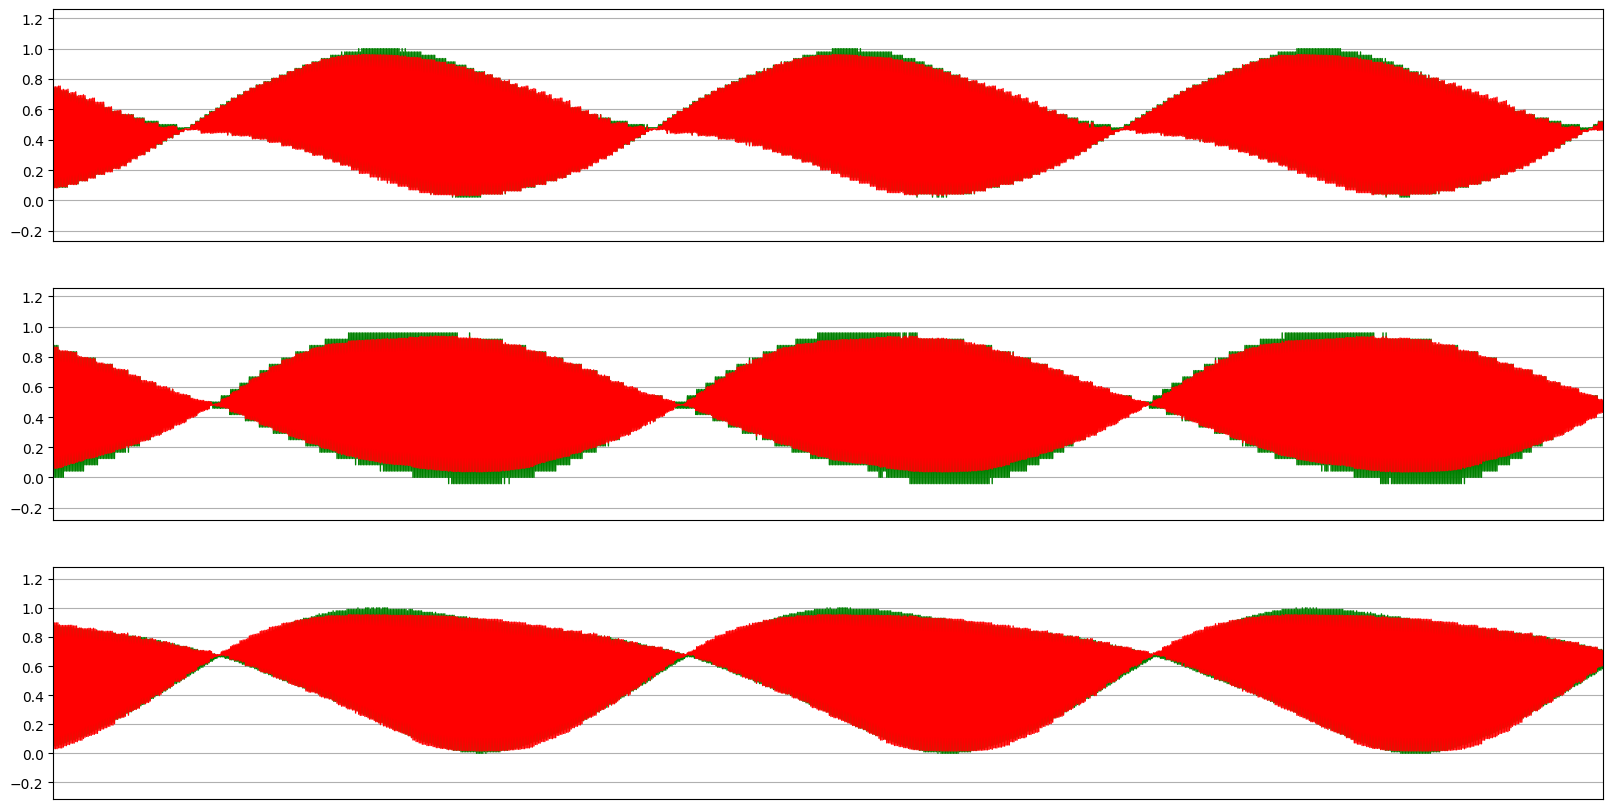

In [ ]:
plotVibPatternEncoded(subset_original, subset_decoded, timestamp)

By looking at the graphs it confirms that our model has indeed learnt the correct features. It is not perfect as there is still some green that is not covered but it is too little to be a concern for now.

Hence, the model proves to be ready.

In [ ]:
anomaly_sample = norm_anomalous_data.iloc[:, :].to_numpy()

In [ ]:
anomaly_sample.shape

(36080, 3)

In [ ]:
encoded_imgs = autoencoder.encoder(anomaly_sample).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Create an array representing the timestamp
timestamp = np.arange(2000)

In [ ]:
# Assuming subset is a NumPy array, not a DataFrame
timestamp = 2000
anomaly_subset_original = anomaly_sample[0:2000]
anomaly_subset_decoded = decoded_imgs[0:2000]
timestamp = np.array([i for i in range(timestamp)])  # Convert to a NumPy array

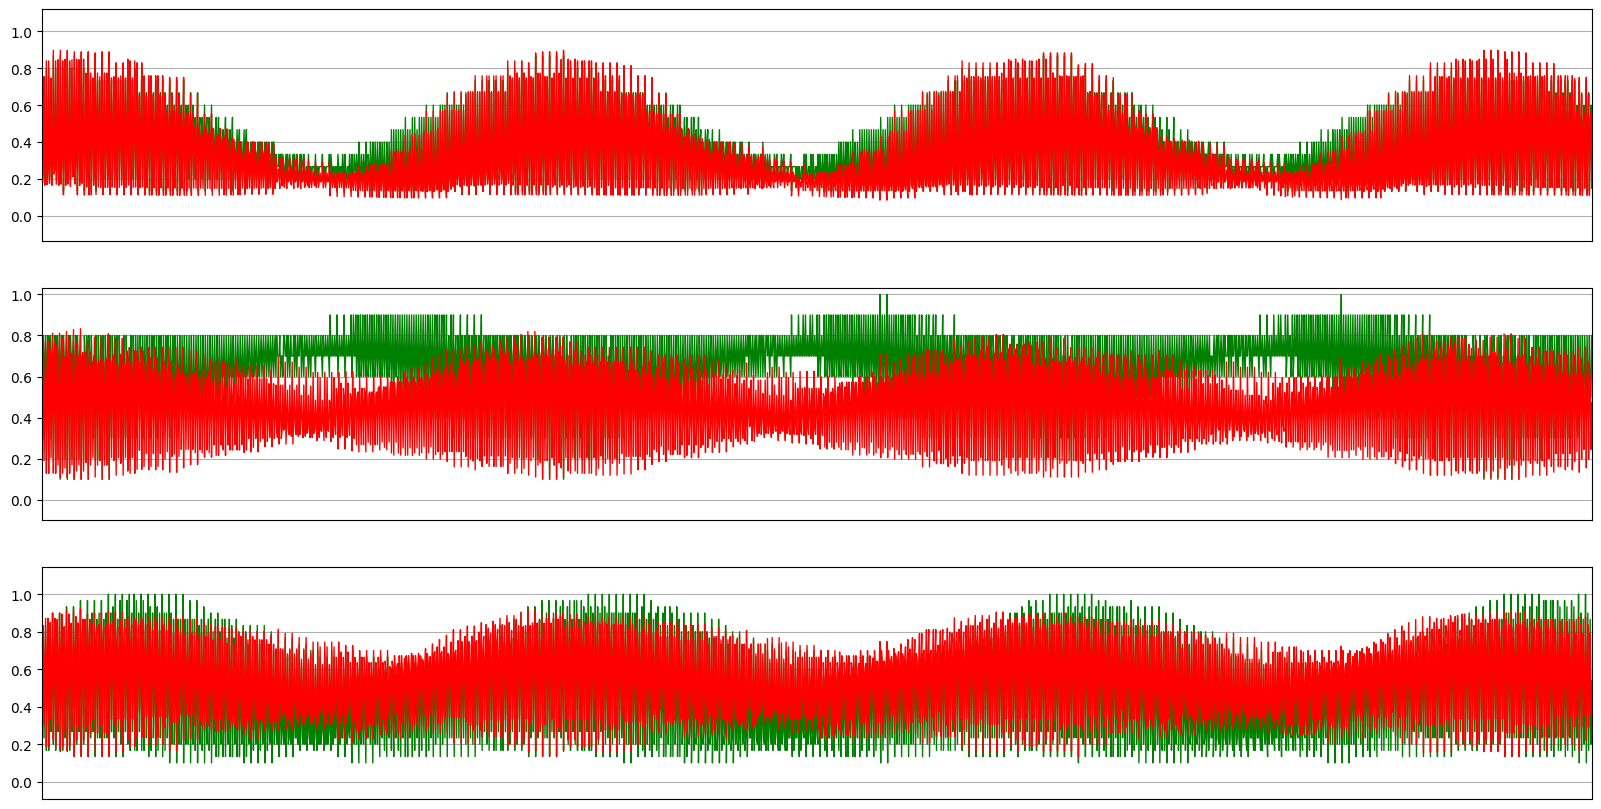

In [ ]:
plotVibPatternEncoded(anomaly_subset_original, anomaly_subset_decoded, timestamp)

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. You will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal accelerometer data from the training set

795/795 [==============================] - 3s 3ms/step


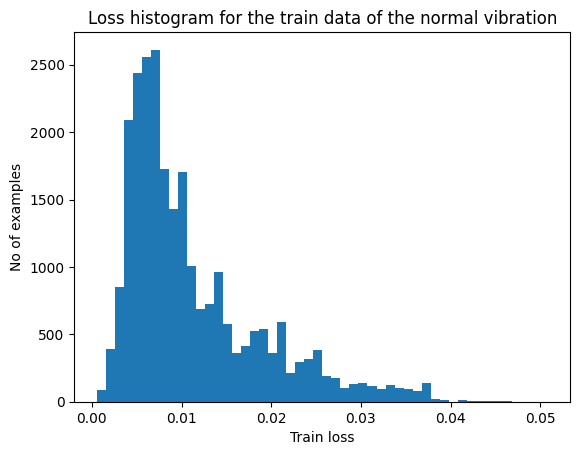

In [ ]:
reconstructions = autoencoder.predict(norm_train_data)
train_loss = tf.keras.losses.mae(reconstructions, norm_train_data)

plt.hist(train_loss, bins=50)
plt.title("Loss histogram for the train data of the normal vibration")
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

113/113 [==============================] - 0s 2ms/step


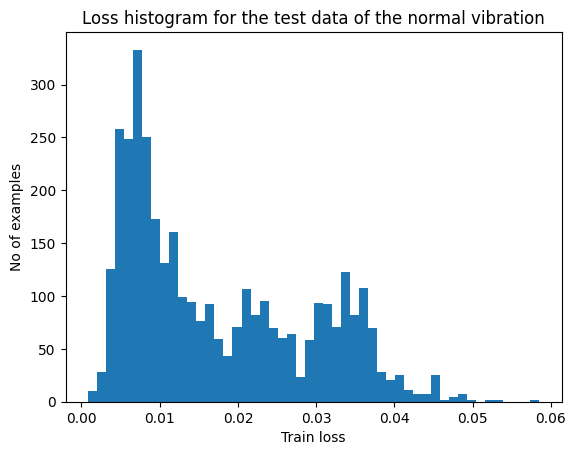

In [ ]:
reconstructions = autoencoder.predict(sample)
test_loss = tf.keras.losses.mae(reconstructions, sample)

plt.hist(test_loss, bins=50)
plt.title("Loss histogram for the test data of the normal vibration")
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

now for the anomalous data

1128/1128 [==============================] - 2s 2ms/step


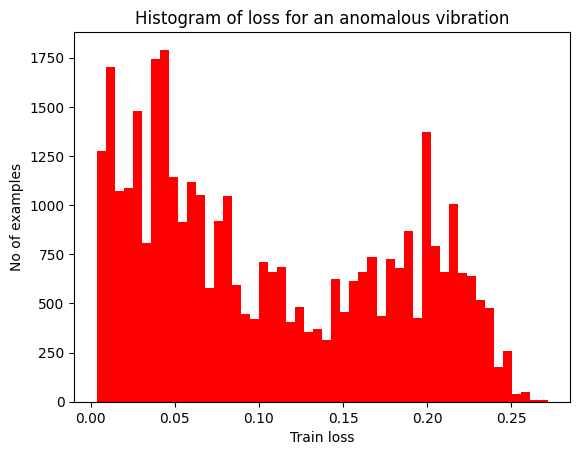

In [ ]:
reconstructions = autoencoder.predict(anomaly_sample)
anomaly_loss = tf.keras.losses.mae(reconstructions, anomaly_sample)

plt.hist(anomaly_loss, bins=50, color = "red")
plt.title("Histogram of loss for an anomalous vibration")
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.01890416083718295


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You will learn more later in the colab.

If you examine the recontruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

### Picking a Threshold to Detect Anomalies
Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.

Try to maximize the accuracy, precision, and recall. Think about the application and the consequences of a false positive and a false negative. The course staff was able to acheive greater than 94% on all three at the same time!

[More details on precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
#or pick it yourself? idk
threshold = 0.04
print("Threshold: ", threshold)

Threshold:  0.04


In [ ]:
len(sample)

3596

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))


In [ ]:
preds, scores = predict(autoencoder, sample, threshold)
test_labels = np.array([True] * len(sample))
print_stats(preds, test_labels)

Accuracy = 0.9733036707452726
Precision = 1.0
Recall = 0.9733036707452726


In [ ]:
# Choose a range of thresholds
thresholds = np.arange(0.01, 0.1, 0.01)  # Adjust the range as needed

val_sample = norm_val_data.iloc[:, :].to_numpy()
val_labels = np.array([True] * len(val_sample))
# Evaluate performance for each threshold on the validation set
for threshold in thresholds:
    preds, _ = predict(autoencoder, val_sample, threshold)
    print("Threshold: {:.4f}".format(threshold))

    print_stats(preds, val_labels)
    print("-----------------------------")

Threshold: 0.0100
Accuracy = 0.3810110974106042
Precision = 1.0
Recall = 0.3810110974106042
-----------------------------
Threshold: 0.0200
Accuracy = 0.716673516920126
Precision = 1.0
Recall = 0.716673516920126
-----------------------------
Threshold: 0.0300
Accuracy = 0.8627209206740649
Precision = 1.0
Recall = 0.8627209206740649
-----------------------------
Threshold: 0.0400
Accuracy = 0.9804082751061789
Precision = 1.0
Recall = 0.9804082751061789
-----------------------------
Threshold: 0.0500
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
-----------------------------
Threshold: 0.0600
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
-----------------------------
Threshold: 0.0700
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
-----------------------------
Threshold: 0.0800
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
-----------------------------
Threshold: 0.0900
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
-----------------------------


## Links to Continue Learning

If you would like to learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow.

To learn more about the basics of autoencoders, try the basis for this colab, [TensorFlow's Intro to Autoencoders](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb#scrollTo=xfNT-mlFwxVM)

For more info, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet, and check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.


Trying to properly quantize

In [ ]:
autoencoder.save("saved_model/my_model")

Perform a simple conversion to TF Lite in order to visualize the model and see what tf Im doing

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model")
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Inspect the size of the model

The Arduino Nano 33 BLE Sense has 1 MB Flash + 256 KB RAM.

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="model.tflite",
                                      model_content=None,
                                      gpu_compatibility=False)


=== model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #11 and tensor #10 as input and produces tensor #21 as output.

Subgraph#0 main(T#0) -> [T#31]
  Op#0 FULLY_CONNECTED(T#0, T#11, T#10) -> [T#21]
  Op#1 FULLY_CONNECTED(T#21, T#12, T#6) -> [T#22]
  Op#2 FULLY_CONNECTED(T#22, T#13, T#7) -> [T#23]
  Op#3 FULLY_CONNECTED(T#23, T#14, T#8) -> [T#24]
  Op#4 FULLY_CONNECTED(T#24, T#15, T#9) -> [T#25]
  Op#5 FULLY_CONNECTED(T#25, T#16, T#1) -> [T#26]
  Op#6 FULLY_CONNECTED(T#26, T#17, T#2) -> [T#27]
  Op#7 FULLY_CONNECTED(T#27, T#18, T#3) -> [T#28]
  Op#8 FULLY_CONNECTED(T#28, T#19, T#4) -> [T#29]
  Op#9 FULLY_CONNECTED(T#29, T#20, T#5) -> [T#30]
  Op#10 LOGISTIC(T#30) -> [T#31]

Tensors of Subgraph#0
  T#0(serving_default_input_1:0) shape_signature:[-1, 3], type:FLOAT32
  T#1(anomaly_detector/sequential_1/dense_5/BiasAdd/ReadVariableOp) sh


#Quantize the model

In [ ]:
def representative_data_gen():
    for input_value in norm_test_data:
        yield tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_value, dtype=tf.float32), -1), 0)

In [ ]:
data = representative_data_gen()

In [ ]:
# Assuming norm_test_data is a Pandas DataFrame
data_gen = (tf.convert_to_tensor(np.expand_dims(np.expand_dims(row, -1), 0), dtype=tf.float32) for _, row in norm_test_data.iterrows())

for d in data_gen:
    break

print(d.shape)

(1, 3, 1)


I don't know why I got this error here. I ran the same code 2 times and it worked, and now the third time it doesn't but this was for me to see that the model can predict d which it did before just as in the CNN model.

In [ ]:
# Flatten the tensor using tf.keras.layers.Flatten
flattened_d = tf.keras.layers.Flatten()(d)

# Now you can use flattened_d in your autoencoder
autoencoder.predict(flattened_d)

1/1 [==============================] - 0s 112ms/step


array([[0.5848338 , 0.47994444, 0.6828107 ]], dtype=float32)

In [ ]:
interpreter = tf.lite.Interpreter(model_content = tflite_model)
print(interpreter.get_signature_list())

{'serving_default': {'inputs': ['input_1'], 'outputs': ['output_1']}}


In [ ]:
# asta e bun cred

####### https://blog.tensorflow.org/2021/03/a-tour-of-savedmodel-signatures.html
###### https://www.tensorflow.org/lite/performance/post_training_quantization

import tensorflow as tf

# Save the model as a SavedModel
tf.saved_model.save(autoencoder, 'saved_model')

# Convert the SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]


# Convert your DataFrame to a TensorFlow Dataset
#test_dataset = tf.data.Dataset.from_tensor_slices(test_normalized_segments.values)

# Define the batch size
batch_size = 32

def representative_data_gen():
    #data_gen = (tf.convert_to_tensor(np.expand_dims(np.expand_dims(row, -1), 0), dtype=tf.float32) for _, row in norm_test_data.iterrows())
    for _, row in norm_test_data.iterrows():
        numeric_values = row[["x-axis", "y-axis", "z-axis"]]  # Replace with the actual column names
        #yield tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(numeric_values, dtype=tf.float32), -1), 0)
        yield {"input_1": tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(numeric_values, dtype=tf.float32), -1), 0)}

'''
# Code from EDX Tiny ML fundamentals course
def representative_data_gen():
    for input_value in test_batch.take(100):
        yield [tf.cast(input_value, tf.float32)]  # Convert to FLOAT32]
'''

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# Save the TensorFlow Lite model
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="converted_model.tflite",
                                      model_content=None,
                                      gpu_compatibility=False)

=== converted_model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #21 as output.

Subgraph#0 main(T#0) -> [T#33]
  Op#0 QUANTIZE(T#0) -> [T#21]
  Op#1 FULLY_CONNECTED(T#21, T#20, T#19[0, 0, -672, -206, 0, ...]) -> [T#22]
  Op#2 FULLY_CONNECTED(T#22, T#18, T#17[-2295, 1132, 5151, 0, 3458, ...]) -> [T#23]
  Op#3 FULLY_CONNECTED(T#23, T#16, T#15[-442, -658, -2440, -631, -543, ...]) -> [T#24]
  Op#4 FULLY_CONNECTED(T#24, T#14, T#13[-424, -953, 0, -23, -517, ...]) -> [T#25]
  Op#5 FULLY_CONNECTED(T#25, T#12, T#11[0, 463, -55, 0, -297, ...]) -> [T#26]
  Op#6 FULLY_CONNECTED(T#26, T#10, T#9[-691, 1097, 575, -283, -141, ...]) -> [T#27]
  Op#7 FULLY_CONNECTED(T#27, T#8, T#7[-1156, -1080, 1916, -82, 0, ...]) -> [T#28]
  Op#8 FULLY_CONNECTED(T#28, T#6, T#5[-1415, 1076, -139, 272, 0, ...]) -> [T#29]
  Op#9 FULLY_CONNECTED(T#29, T#4, T#3[

#EXTRA STUFF FROM THIS POINT ON

Before anything this is a note to myself as I will be continuing developing code here and I will add further information after some research to see what time of model would be best for our problem.

- Anomaly detection, which is also known as classification (It's the "What" and "Which" type of questions when working with classification when working with timeseries data). The output is discrete, meaning that it's usually it is an anomaly or it isn't an anomaly.
- Frecasting (questions such as how much and how many). Output is continuous (range of values)

Challenges collecting data in anomaly detection:
- the data is often unbalanced
- anomalous data can be expensive or dangerous to capture

Methods for accurate and efficient anomaly detection: **K-means clustering, auto-encoders as well as neural networks**.